<a href="https://colab.research.google.com/github/jafar-albadarneh/data-science-pot/blob/master/Analyzing_Police_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Police Traffic Stop Activity Dataset
The dataset contains the following columns:
- State
- Stop Date
- Stop Time
- County Name
- Driver Gender
- Driver Race
- Violation Raw
- Violation
- Search Conducted
- Search Type
- Stop Outcome
- Is Arrested
- Stop Duration
- Drugs Related Stop
- District

In [0]:
# Generics
sns.set()

In [10]:
data = pd.read_csv('https://assets.datacamp.com/production/repositories/1497/datasets/62bd9feef451860db02d26553613a299721882e8/police.csv', header=0, delimiter=',')
# get a better idea about dataset attributes
print(data.shape)

(91741, 15)


## Data Cleaning


### Check and handle missing values

> Drop column `county_name` as all of its values are null

In [11]:
print(data.isna().sum())
# Drop `county_name` column since it has no-values (total missing values = # instances)
data.drop(columns='county_name', axis='columns', inplace= True)
print(data.shape)

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64
(91741, 14)


> Drop instances where values for `stop_date`, `stop_time`, `driver_gender` is/are not set, since these are critical data attributes for the study

In [13]:
data.dropna(subset=['stop_date', 'stop_time', 'driver_gender'], inplace=True)
print(data.shape)

(86536, 14)


### Fix Improper datatypes

Most of the columns has the type `object` which denotes a string or other python object other than (int, float, bool, datetime, category)

In [14]:
print(data.dtypes)

state                 object
stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object


> Fix `is_arrested` type 'object' to 'bool'

In [16]:
data['is_arrested'] = data.is_arrested.astype('bool')
print(data.is_arrested.dtype)

bool


> `stop_date` & `stop_time` are the most important attributes for the analysis. In order to leverage datatime operations capability of pandas, we can create a `datetime` index on a combined version of the two

In [19]:
datetime_series = data.stop_date.str.cat(data.stop_time, sep=' ')
data['stop_datetime'] = pd.to_datetime(datetime_series)
# set datetime attribute as index for easier querying and plotting
data.set_index('stop_datetime', inplace=True)
print(data.head(1))

                    state   stop_date  ... drugs_related_stop district
stop_datetime                          ...                            
2005-01-04 12:55:00    RI  2005-01-04  ...              False  Zone X4

[1 rows x 14 columns]


## Data Analysis

### Gender-based analysis

Analyzing `driver_gender` and its relation to data.

M    62762
F    23774
Name: driver_gender, dtype: int64


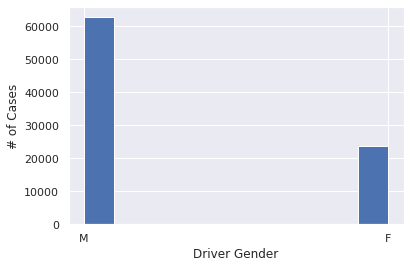

In [24]:
data.driver_gender.hist()
plt.xlabel('Driver Gender')
plt.ylabel('# of Cases')
plt.show()

Examining Traffic Violation

In [31]:
data.violation.value_counts(normalize=True)

Speeding               0.559571
Moving violation       0.187483
Equipment              0.126202
Other                  0.050950
Registration/plates    0.042791
Seat belt              0.033004
Name: violation, dtype: float64

The numbers show that more than ***50%*** of the cases was due to **`Speeding`**, let's compare the numbers for both genders (Male, Female)

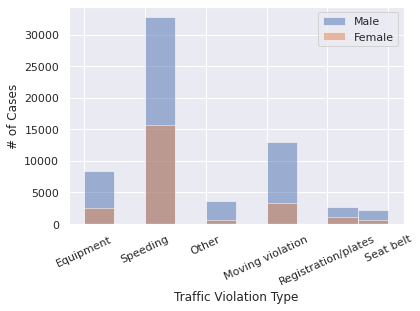

In [33]:
males_cases = data[data.driver_gender == 'M']
females_cases = data[data.driver_gender == 'F']
males_cases.violation.hist(alpha=0.5)
females_cases.violation.hist(alpha=0.5)
plt.xlabel('Traffic Violation Type')
plt.ylabel('# of Cases')
plt.xticks(rotation=25)
plt.legend(['Male', 'Female'])
plt.show()

It's crystal clear that `males` tends to commit more traffic violations in comparison with `females` with the fact that `speeding` is the most common violation type among both genders.

**Does `driver_gender` decides whose vehicle is searched?**

> Note: when performing `mean()` on a boolean series, it returns the percentage of the `True` values inside the series


In [42]:
arrest_rates_by_gender = data.groupby('driver_gender').is_arrested.mean() * 100
print(arrest_rates_by_gender)

driver_gender
F    2.813998
M    3.838310
Name: is_arrested, dtype: float64


**A Deeper look into search correlation with violation type**

In [44]:
print(data.groupby(['driver_gender', 'violation']).search_conducted.mean() * 100)

driver_gender  violation          
F              Equipment               3.998401
               Moving violation        3.925746
               Other                   4.101839
               Registration/plates     5.492424
               Seat belt               1.730104
               Speeding                0.830883
M              Equipment               7.149644
               Moving violation        6.152419
               Other                   4.619125
               Registration/plates    10.880242
               Seat belt               3.511853
               Speeding                2.788541
Name: search_conducted, dtype: float64


Numbers tell that (Expired Registration/Invalid Plates) are the most violation types for both genders which ended with a vehicle search.

### Time-based Analysis

**Monthly Arrest Rates**

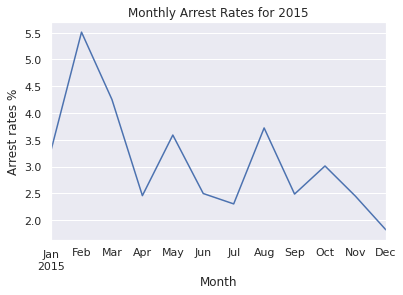

In [56]:
arrest_rates_2015 = data[data.index.year == 2015].is_arrested.resample('M').mean() * 100
arrest_rates_2015.plot()
plt.xlabel('Month')
plt.ylabel('Arrest rates %')
plt.title('Monthly Arrest Rates for 2015')
plt.show()

**Annual Rate of Drug-Related Stops**

You'll notice that drug-related stops have rosen over the years



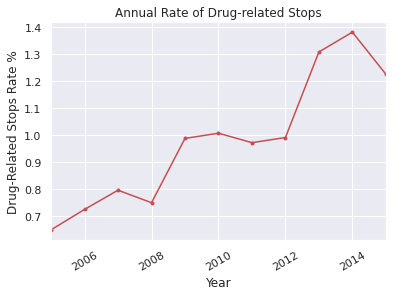

In [58]:
annual_drug_rate = data.drugs_related_stop.resample('A').mean() * 100
annual_drug_rate.plot(color='r', marker='.')
plt.xlabel('Year')
plt.ylabel('Drug-Related Stops Rate %')
plt.xticks(rotation=30)
plt.title('Annual Rate of Drug-related Stops')
plt.show()

**Annual Rate of Drug-Related vs Search-Conducted Stops**

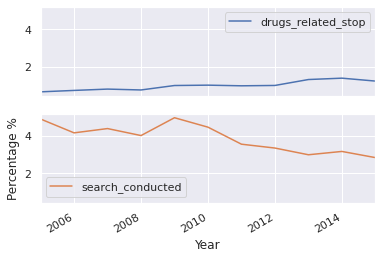

In [65]:
annual_search_conducted = data.search_conducted.resample('A').mean() * 100
annual_combined = pd.concat([annual_drug_rate, annual_search_conducted], axis='columns')
fig, ax = annual_combined.plot(subplots=True, sharey=True)
plt.xlabel('Year')
plt.ylabel('Percentage %')
plt.show()